# Clasificación de casos de estenosis coronaria usando Visual Transformers

### @Author Daniel Vallejo Aldana // Licenciatura en computación

#### Procesamiento de Imágenes biomédicas

In [1]:
import os
from transformers import ViTModel, ViTConfig, ViTForImageClassification
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import random_split,Dataset,DataLoader
from torch.optim import Adam
from time import time
from sklearn.metrics import classification_report, accuracy_score,f1_score
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import patchify
import cv2
from time import process_time 
import datetime

## Declaración de la clase que nos ayudará a cargar los datos de los archivos .pickle a tensores para clasificación

In [2]:
class EstenosisDS(Dataset):
    def __init__(self,pos_data,neg_data,ratios=(0.7,0.15,0.5),handle_negatives=None):
        '''
        La clase se inicializa con los paths the los archivos pickle que debemos tener, el radio
        de separación de los conjuntos de prueba, validación y prueba
        handle_negatives tiene dos opciones
        balance <- deja el mismo número de ejemplos positivos y negativos
        None<-Deja el conjunto de datos tal cual está
        '''
        self.ratios=ratios
        self.labels=[]
        file = open(pos_data, 'rb')
        positive_data = pickle.load(file)
        file.close()
        for i in range(positive_data.shape[0]):
            self.labels.append(np.array(1))
        file = open(neg_data, 'rb')
        negative_data = pickle.load(file)
        np.random.shuffle(negative_data)
        file.close()
        if handle_negatives is not None and type(handle_negatives)==int and handle_negatives<=10:
            negative_data=negative_data[:handle_negatives*positive_data.shape[0],:,:]
        for i in range(negative_data.shape[0]):
            self.labels.append(np.array(0))
        self.labels=np.asarray(self.labels)
        self.all=np.concatenate((positive_data,negative_data),axis=0)
        zero_dim=self.all.shape[0]
        self.all=np.asarray([np.asarray(Image.fromarray(self.all[i]*255,mode="L")) for i in range(self.all.shape[0])])
        batch,d1,d2=self.all.shape
        self.all=self.all.reshape(batch,1,d1,d2)
    
    def __len__(self):
        assert(self.all.shape[0]==self.labels.shape[0])
        return self.labels.shape[0]
    def __getitem__(self,index):
        return self.all[index],self.labels[index]
    def split_dataset(self):
        tr_ratio,val_ratio,test_ratio=self.ratios
        train_size = int(tr_ratio*self.__len__())
        val_size = int(val_ratio*self.__len__())
        test_size = int(test_ratio*self.__len__())
        train,test = random_split(self,[train_size,self.__len__()-train_size])
        test, val = random_split(test, [self.__len__()-train_size-val_size,val_size])
        test,_=random_split(test, [test_size,self.__len__()-train_size-val_size-test_size])
        return train,val,test
    @staticmethod
    def load_data(ds1,ds2,ds3,batch_size=4):
        train_dl=DataLoader(ds1,batch_size=batch_size,shuffle=True)
        val_dl=DataLoader(ds2,batch_size=batch_size,shuffle=False)
        test_dl=DataLoader(ds3,batch_size=batch_size,shuffle=False)
        return train_dl,val_dl,test_dl
    def load_single_set(ds,batch_size=4,shuffle=False):
        dataloader=DataLoader(ds,batch_size=batch_size,shuffle=shuffle)

In [3]:
ds=EstenosisDS('125x32x32 positive.pickle','1394x32x32 negative.pickle',handle_negatives=1)
train_ds,val_ds,test_ds=ds.split_dataset()

In [4]:
ds.all.shape

(250, 1, 32, 32)

In [5]:
train_dl,val_dl,test_dl=ds.load_data(train_ds,val_ds,test_ds)

In [6]:
#Con esto ya tenemos todo listo para alimentar a la red neuronal
it=iter(train_dl)
x,y=next(it)
print(x.size(),y.size())

torch.Size([4, 1, 32, 32]) torch.Size([4])


# Definición del modelo de Visual Transformer para clasificación

In [7]:
class ViTEstDet(nn.Module):
    def __init__(self,image_size=32,patch_size=16,channels=1,hidden_size=768, num_hidden_layers=12, num_attention_heads=12,attention_probs_dropout_prob=0.0):
        super(ViTEstDet,self).__init__()
        self.config=ViTConfig(image_size=image_size,patch_size=patch_size,hidden_size=hidden_size,num_channels=channels,attention_probs_dropout_prob=attention_probs_dropout_prob,num_hidden_layers=num_hidden_layers,num_attention_heads=num_attention_heads)
        self.vit = ViTForImageClassification(self.config)
        self.device="cuda:0" if next(self.parameters()).is_cuda else "cpu"
        
    def forward(self,pixel_values,output_attentions=False):
        '''
        input_fxt --> Feature extractor input
        '''
        if output_attentions:
            X = self.vit(pixel_values=pixel_values,output_attentions=True)
            x = X.pooler_output
        else:
            x = self.vit(pixel_values=pixel_values)[0]
        return x
    @torch.no_grad()
    def eval_model(self,dl):
        self.eval() #Ponemos el modelo en modo de evaluación
        flag=False
        if next(self.parameters()).is_cuda:
            flag=True
            self.cpu() #Y todo el modelo se manda a dispositivo cpu
        else:
            self.cpu()
        Y_real=[]
        Y_pred=[]
        for x,y in dl:
            y_pred=self.forward(x.float())
            y=y.numpy().tolist()
            y_pred=torch.argmax(y_pred,dim=1).numpy().tolist()
            Y_real=Y_real+y
            Y_pred=Y_pred+y_pred
        Y_real=np.array(Y_real)
        Y_pred=np.array(Y_pred)
        self.train() #Regresamos el modelo al módulo de entrenamiento
        if flag:
            self.cuda() #Y regresamos el modelo a GPU
        return Y_real,Y_pred
    
    def predict(self,image):
        t1_start = process_time()
        was_training=self.training
        self.eval() #Ponemos el modelo en modo de evaluación
        imagen=cv2.imread(image,0)
        wi,he=imagen.shape
        imagen=imagen.reshape(1,wi,he)
        patches = patchify.patchify(imagen, (1, 32, 32), step=32)
        toUnpatch=patches.shape
        patches=patches.reshape(-1,1,32,32)
        TensorPatches=torch.FloatTensor(patches)
        Custom_batches=torch.split(TensorPatches, 16, dim=0)
        mask=[]
        for batch in Custom_batches:
            y_pred=self.forward(batch)
            preds=torch.argmax(y_pred,dim=1).numpy().tolist()
            mask=mask+preds
        mask=np.asarray(mask).reshape(toUnpatch[1],toUnpatch[2])
        t2_start = process_time() #Medir el tiempo de inferencia
        if was_training:
            self.train() #Regresamos a modo de entrenamiento si es que el modelo ya estaba en modo de entrenamiento
        return mask

In [8]:
#feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTEstDet()

In [9]:
training=True
if training:
    assert(torch.cuda.is_available()==True)
device="cuda:0" if training else "cpu" #Inferencia se puede hacer con cpu sin problemas
if training:
    print("Dispositivo de entrenamiento: ",torch.cuda.get_device_name(0))

Dispositivo de entrenamiento:  NVIDIA GeForce RTX 2080 Ti


In [10]:
#Definción de hiperparametros como optimizadores y epocas
epochs=100 #Es lo mismo que ponen en YOLO y en ViT 
loss_f=nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters()) #optimizadores adaptativos para datos dispersos
model=model.to(device)

In [12]:
#Ciclo de entrenamiento
improve=[]
if torch.cuda.is_available():
    torch.cuda.empty_cache()
best_f1=-float('inf')
best_loss=float('inf')
save_checkpoint=False
model_name=model.__class__.__name__+str(datetime.date.today())+".pt"
for epoch in tqdm(range(epochs)):
    avg_loss=0.0
    for x,y in train_dl:
        optimizer.zero_grad()
        x=x.to(device)
        y=y.to(device)
        y_pred=model(x.float()) #Metemos la imagen para inferencia
        loss=loss_f(y_pred,y)
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()
    a,b=model.eval_model(val_dl)
    assert(model.training==True) #Checamos que el modelo se siga entrenando
    f1_validacion=classification_report(a,b)
    print("Done {}/{} Epochs with loss {} Memory Usage {} Gb".format(epoch+1,epochs,avg_loss/len(train_dl),round(torch.cuda.memory_allocated(0)/1e9,2)))
    print(f1_validacion)
    #Guardamos el mejor modelo de lo ya obtenido
    current_f1=round(f1_score(a,b,average='macro'),2)
    current_loss=round(avg_loss/len(train_dl),3)
    if current_f1>=best_f1 and avg_loss/len(train_dl) < 0.22:
        improve.append(current_f1)
        if current_loss<best_loss and current_f1==best_f1:
            if save_checkpoint:
                torch.save(model,model_name)
                print("Guardando modelo por mejora en el F1-score de {} a {}".format(best_f1,current_f1))
        if save_checkpoint:
            torch.save(model,model_name)
            print("Guardando modelo por mejora en el F1-score de {} a {}".format(best_f1,current_f1))
        best_f1=current_f1
if not save_checkpoint:
    torch.save(model,model_name) 

  0%|          | 0/100 [00:00<?, ?it/s]/home/daniel.vallejo/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 1/100 [00:02<03:42,  2.25s/it]

Done 1/100 Epochs with loss 1.8045751249248332 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

Done 2/100 Epochs with loss 0.9458763328465548 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.51      1.00      0.68        19

    accuracy                           0.51        37
   macro avg       0.26      0.50      0.34        37
weighted avg       0.26      0.51      0.35        37



  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

Done 3/100 Epochs with loss 0.8716951710256663 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



  4%|▍         | 4/100 [00:08<03:22,  2.11s/it]

Done 4/100 Epochs with loss 0.8272040330550887 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.51      1.00      0.68        19

    accuracy                           0.51        37
   macro avg       0.26      0.50      0.34        37
weighted avg       0.26      0.51      0.35        37



  5%|▌         | 5/100 [00:10<03:18,  2.09s/it]

Done 5/100 Epochs with loss 0.7391869290308519 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



  6%|▌         | 6/100 [00:12<03:15,  2.08s/it]

Done 6/100 Epochs with loss 0.7757231417027387 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.51      1.00      0.68        19

    accuracy                           0.51        37
   macro avg       0.26      0.50      0.34        37
weighted avg       0.26      0.51      0.35        37



  7%|▋         | 7/100 [00:14<03:12,  2.07s/it]

Done 7/100 Epochs with loss 0.7520014260980216 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



  8%|▊         | 8/100 [00:16<03:09,  2.06s/it]

Done 8/100 Epochs with loss 0.7386063865639947 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.11      0.20        18
           1       0.54      1.00      0.70        19

    accuracy                           0.57        37
   macro avg       0.77      0.56      0.45        37
weighted avg       0.77      0.57      0.46        37



  9%|▉         | 9/100 [00:18<03:06,  2.05s/it]

Done 9/100 Epochs with loss 0.6898915666070852 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 10%|█         | 10/100 [00:20<03:05,  2.06s/it]

Done 10/100 Epochs with loss 0.6938024589961226 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.53      1.00      0.69        19

    accuracy                           0.54        37
   macro avg       0.76      0.53      0.40        37
weighted avg       0.76      0.54      0.41        37



 11%|█         | 11/100 [00:22<03:02,  2.06s/it]

Done 11/100 Epochs with loss 0.6747034456242215 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 12%|█▏        | 12/100 [00:24<03:00,  2.05s/it]

Done 12/100 Epochs with loss 0.7087797319347208 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 13%|█▎        | 13/100 [00:26<02:57,  2.04s/it]

Done 13/100 Epochs with loss 0.676271220499819 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 14%|█▍        | 14/100 [00:28<02:55,  2.04s/it]

Done 14/100 Epochs with loss 0.6921572827480056 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        18
           1       0.47      0.47      0.47        19

    accuracy                           0.46        37
   macro avg       0.46      0.46      0.46        37
weighted avg       0.46      0.46      0.46        37



 15%|█▌        | 15/100 [00:30<02:54,  2.06s/it]

Done 15/100 Epochs with loss 0.7132264788855206 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 16%|█▌        | 16/100 [00:32<02:52,  2.05s/it]

Done 16/100 Epochs with loss 0.6483606269413774 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 17%|█▋        | 17/100 [00:34<02:49,  2.04s/it]

Done 17/100 Epochs with loss 0.6810200051827864 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.11      0.20        18
           1       0.54      1.00      0.70        19

    accuracy                           0.57        37
   macro avg       0.77      0.56      0.45        37
weighted avg       0.77      0.57      0.46        37



 18%|█▊        | 18/100 [00:36<02:47,  2.04s/it]

Done 18/100 Epochs with loss 0.6445012946020473 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.11      0.18        18
           1       0.52      0.89      0.65        19

    accuracy                           0.51        37
   macro avg       0.51      0.50      0.42        37
weighted avg       0.51      0.51      0.42        37



 19%|█▉        | 19/100 [00:39<02:45,  2.04s/it]

Done 19/100 Epochs with loss 0.7370421297170899 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.53      1.00      0.69        19

    accuracy                           0.54        37
   macro avg       0.76      0.53      0.40        37
weighted avg       0.76      0.54      0.41        37



 20%|██        | 20/100 [00:41<02:42,  2.04s/it]

Done 20/100 Epochs with loss 0.7042875960469246 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.11      0.20        18
           1       0.54      1.00      0.70        19

    accuracy                           0.57        37
   macro avg       0.77      0.56      0.45        37
weighted avg       0.77      0.57      0.46        37



 21%|██        | 21/100 [00:43<02:40,  2.03s/it]

Done 21/100 Epochs with loss 0.7323425110768188 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.53      1.00      0.69        19

    accuracy                           0.54        37
   macro avg       0.76      0.53      0.40        37
weighted avg       0.76      0.54      0.41        37



 22%|██▏       | 22/100 [00:45<02:38,  2.03s/it]

Done 22/100 Epochs with loss 0.6037758771668781 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 23%|██▎       | 23/100 [00:47<02:36,  2.03s/it]

Done 23/100 Epochs with loss 0.6243252916769548 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.53      1.00      0.69        19

    accuracy                           0.54        37
   macro avg       0.76      0.53      0.40        37
weighted avg       0.76      0.54      0.41        37



 24%|██▍       | 24/100 [00:49<02:34,  2.03s/it]

Done 24/100 Epochs with loss 0.6392815248532728 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.43      0.17      0.24        18
           1       0.50      0.79      0.61        19

    accuracy                           0.49        37
   macro avg       0.46      0.48      0.43        37
weighted avg       0.47      0.49      0.43        37



 25%|██▌       | 25/100 [00:51<02:32,  2.03s/it]

Done 25/100 Epochs with loss 0.633984390984882 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.40      0.22      0.29        18
           1       0.48      0.68      0.57        19

    accuracy                           0.46        37
   macro avg       0.44      0.45      0.43        37
weighted avg       0.44      0.46      0.43        37



 26%|██▌       | 26/100 [00:53<02:30,  2.03s/it]

Done 26/100 Epochs with loss 0.6499694558707151 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.53      0.56      0.54        18
           1       0.56      0.53      0.54        19

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.54        37
weighted avg       0.54      0.54      0.54        37



 27%|██▋       | 27/100 [00:55<02:28,  2.03s/it]

Done 27/100 Epochs with loss 0.5897303690964525 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.17      0.25        18
           1       0.52      0.84      0.64        19

    accuracy                           0.51        37
   macro avg       0.51      0.50      0.44        37
weighted avg       0.51      0.51      0.45        37



 28%|██▊       | 28/100 [00:57<02:26,  2.03s/it]

Done 28/100 Epochs with loss 0.700671199709177 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.53      1.00      0.69        19

    accuracy                           0.54        37
   macro avg       0.76      0.53      0.40        37
weighted avg       0.76      0.54      0.41        37



 29%|██▉       | 29/100 [00:59<02:24,  2.03s/it]

Done 29/100 Epochs with loss 0.6335216923193498 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.53      0.56      0.54        18
           1       0.56      0.53      0.54        19

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.54        37
weighted avg       0.54      0.54      0.54        37



 30%|███       | 30/100 [01:01<02:22,  2.03s/it]

Done 30/100 Epochs with loss 0.5917779291895303 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.54      0.39      0.45        18
           1       0.54      0.68      0.60        19

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.53        37
weighted avg       0.54      0.54      0.53        37



 31%|███       | 31/100 [01:03<02:20,  2.03s/it]

Done 31/100 Epochs with loss 0.5869680167260495 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        18
           1       0.00      0.00      0.00        19

    accuracy                           0.49        37
   macro avg       0.24      0.50      0.33        37
weighted avg       0.24      0.49      0.32        37



 32%|███▏      | 32/100 [01:05<02:18,  2.04s/it]

Done 32/100 Epochs with loss 0.5674054612490264 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.57      0.44      0.50        18
           1       0.57      0.68      0.62        19

    accuracy                           0.57        37
   macro avg       0.57      0.56      0.56        37
weighted avg       0.57      0.57      0.56        37



 33%|███▎      | 33/100 [01:07<02:16,  2.04s/it]

Done 33/100 Epochs with loss 0.5399167327718302 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.53      1.00      0.69        19

    accuracy                           0.54        37
   macro avg       0.76      0.53      0.40        37
weighted avg       0.76      0.54      0.41        37



 34%|███▍      | 34/100 [01:09<02:14,  2.04s/it]

Done 34/100 Epochs with loss 0.5513134913688357 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        18
           1       0.53      0.47      0.50        19

    accuracy                           0.51        37
   macro avg       0.51      0.51      0.51        37
weighted avg       0.52      0.51      0.51        37



 35%|███▌      | 35/100 [01:11<02:12,  2.04s/it]

Done 35/100 Epochs with loss 0.5250479501079429 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.48      0.67      0.56        18
           1       0.50      0.32      0.39        19

    accuracy                           0.49        37
   macro avg       0.49      0.49      0.47        37
weighted avg       0.49      0.49      0.47        37



 36%|███▌      | 36/100 [01:13<02:10,  2.03s/it]

Done 36/100 Epochs with loss 0.5435041710734367 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.54      0.39      0.45        18
           1       0.54      0.68      0.60        19

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.53        37
weighted avg       0.54      0.54      0.53        37



 37%|███▋      | 37/100 [01:15<02:08,  2.04s/it]

Done 37/100 Epochs with loss 0.5003629811108112 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.54      0.39      0.45        18
           1       0.54      0.68      0.60        19

    accuracy                           0.54        37
   macro avg       0.54      0.54      0.53        37
weighted avg       0.54      0.54      0.53        37



 38%|███▊      | 38/100 [01:17<02:06,  2.04s/it]

Done 38/100 Epochs with loss 0.48090767386284744 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.72      0.59        18
           1       0.55      0.32      0.40        19

    accuracy                           0.51        37
   macro avg       0.52      0.52      0.50        37
weighted avg       0.52      0.51      0.49        37



 39%|███▉      | 39/100 [01:19<02:04,  2.04s/it]

Done 39/100 Epochs with loss 0.4722265149890022 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.60      0.63      0.62        19

    accuracy                           0.59        37
   macro avg       0.59      0.59      0.59        37
weighted avg       0.59      0.59      0.59        37



 40%|████      | 40/100 [01:21<02:02,  2.03s/it]

Done 40/100 Epochs with loss 0.48797343925318937 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.52      0.72      0.60        18
           1       0.58      0.37      0.45        19

    accuracy                           0.54        37
   macro avg       0.55      0.55      0.53        37
weighted avg       0.55      0.54      0.53        37



 41%|████      | 41/100 [01:23<01:59,  2.03s/it]

Done 41/100 Epochs with loss 0.47941021367230197 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.57      0.44      0.50        18
           1       0.57      0.68      0.62        19

    accuracy                           0.57        37
   macro avg       0.57      0.56      0.56        37
weighted avg       0.57      0.57      0.56        37



 42%|████▏     | 42/100 [01:25<01:57,  2.03s/it]

Done 42/100 Epochs with loss 0.4855746321210807 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.52      0.72      0.60        18
           1       0.58      0.37      0.45        19

    accuracy                           0.54        37
   macro avg       0.55      0.55      0.53        37
weighted avg       0.55      0.54      0.53        37



 43%|████▎     | 43/100 [01:27<01:55,  2.04s/it]

Done 43/100 Epochs with loss 0.45948936316100036 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.60      0.33      0.43        18
           1       0.56      0.79      0.65        19

    accuracy                           0.57        37
   macro avg       0.58      0.56      0.54        37
weighted avg       0.58      0.57      0.54        37



 44%|████▍     | 44/100 [01:29<01:53,  2.03s/it]

Done 44/100 Epochs with loss 0.4307302788153968 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.52      0.67      0.59        18
           1       0.57      0.42      0.48        19

    accuracy                           0.54        37
   macro avg       0.55      0.54      0.54        37
weighted avg       0.55      0.54      0.53        37



 45%|████▌     | 45/100 [01:31<01:51,  2.03s/it]

Done 45/100 Epochs with loss 0.3844170095399022 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.46      0.33      0.39        18
           1       0.50      0.63      0.56        19

    accuracy                           0.49        37
   macro avg       0.48      0.48      0.47        37
weighted avg       0.48      0.49      0.47        37



 46%|████▌     | 46/100 [01:33<01:49,  2.03s/it]

Done 46/100 Epochs with loss 0.431253003125841 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        18
           1       0.62      0.68      0.65        19

    accuracy                           0.62        37
   macro avg       0.62      0.62      0.62        37
weighted avg       0.62      0.62      0.62        37



 47%|████▋     | 47/100 [01:35<01:47,  2.03s/it]

Done 47/100 Epochs with loss 0.4051293312381445 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.73      0.44      0.55        18
           1       0.62      0.84      0.71        19

    accuracy                           0.65        37
   macro avg       0.67      0.64      0.63        37
weighted avg       0.67      0.65      0.63        37



 48%|████▊     | 48/100 [01:37<01:45,  2.03s/it]

Done 48/100 Epochs with loss 0.3998604725136168 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.47      0.89      0.62        18
           1       0.33      0.05      0.09        19

    accuracy                           0.46        37
   macro avg       0.40      0.47      0.35        37
weighted avg       0.40      0.46      0.35        37



 49%|████▉     | 49/100 [01:40<01:43,  2.03s/it]

Done 49/100 Epochs with loss 0.4047886562660675 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.17      0.25        18
           1       0.52      0.84      0.64        19

    accuracy                           0.51        37
   macro avg       0.51      0.50      0.44        37
weighted avg       0.51      0.51      0.45        37



 50%|█████     | 50/100 [01:42<01:41,  2.03s/it]

Done 50/100 Epochs with loss 0.3215839648619294 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        18
           1       0.57      0.84      0.68        19

    accuracy                           0.59        37
   macro avg       0.62      0.59      0.56        37
weighted avg       0.62      0.59      0.57        37



 51%|█████     | 51/100 [01:44<01:39,  2.03s/it]

Done 51/100 Epochs with loss 0.28989005693636666 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.59      0.53      0.56        19

    accuracy                           0.57        37
   macro avg       0.57      0.57      0.57        37
weighted avg       0.57      0.57      0.57        37



 52%|█████▏    | 52/100 [01:46<01:37,  2.03s/it]

Done 52/100 Epochs with loss 0.4083399820161007 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.46      0.67      0.55        18
           1       0.45      0.26      0.33        19

    accuracy                           0.46        37
   macro avg       0.46      0.46      0.44        37
weighted avg       0.46      0.46      0.44        37



 53%|█████▎    | 53/100 [01:48<01:35,  2.03s/it]

Done 53/100 Epochs with loss 0.3283254135061394 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.59      0.53      0.56        19

    accuracy                           0.57        37
   macro avg       0.57      0.57      0.57        37
weighted avg       0.57      0.57      0.57        37



 54%|█████▍    | 54/100 [01:50<01:33,  2.03s/it]

Done 54/100 Epochs with loss 0.2870802560884675 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.62      0.28      0.38        18
           1       0.55      0.84      0.67        19

    accuracy                           0.57        37
   macro avg       0.59      0.56      0.53        37
weighted avg       0.59      0.57      0.53        37



 55%|█████▌    | 55/100 [01:52<01:31,  2.03s/it]

Done 55/100 Epochs with loss 0.2857198810247196 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.69      0.61      0.65        18
           1       0.67      0.74      0.70        19

    accuracy                           0.68        37
   macro avg       0.68      0.67      0.67        37
weighted avg       0.68      0.68      0.67        37



 56%|█████▌    | 56/100 [01:54<01:29,  2.03s/it]

Done 56/100 Epochs with loss 0.33878117017130455 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.48      0.61      0.54        18
           1       0.50      0.37      0.42        19

    accuracy                           0.49        37
   macro avg       0.49      0.49      0.48        37
weighted avg       0.49      0.49      0.48        37



 57%|█████▋    | 57/100 [01:56<01:27,  2.03s/it]

Done 57/100 Epochs with loss 0.21392864270918918 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.78      0.61        18
           1       0.56      0.26      0.36        19

    accuracy                           0.51        37
   macro avg       0.53      0.52      0.48        37
weighted avg       0.53      0.51      0.48        37



 58%|█████▊    | 58/100 [01:58<01:25,  2.03s/it]

Done 58/100 Epochs with loss 0.27079829981084913 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        18
           1       0.58      0.58      0.58        19

    accuracy                           0.57        37
   macro avg       0.57      0.57      0.57        37
weighted avg       0.57      0.57      0.57        37



 59%|█████▉    | 59/100 [02:00<01:23,  2.04s/it]

Done 59/100 Epochs with loss 0.2899671391268816 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        18
           1       0.57      0.63      0.60        19

    accuracy                           0.57        37
   macro avg       0.57      0.57      0.56        37
weighted avg       0.57      0.57      0.57        37



 60%|██████    | 60/100 [02:02<01:21,  2.04s/it]

Done 60/100 Epochs with loss 0.24919107943159444 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        18
           1       0.62      0.53      0.57        19

    accuracy                           0.59        37
   macro avg       0.60      0.60      0.59        37
weighted avg       0.60      0.59      0.59        37



 61%|██████    | 61/100 [02:04<01:19,  2.03s/it]

Done 61/100 Epochs with loss 0.28603443126617506 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.73      0.44      0.55        18
           1       0.62      0.84      0.71        19

    accuracy                           0.65        37
   macro avg       0.67      0.64      0.63        37
weighted avg       0.67      0.65      0.63        37



 62%|██████▏   | 62/100 [02:06<01:17,  2.03s/it]

Done 62/100 Epochs with loss 0.23378019479357384 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        18
           1       0.53      0.47      0.50        19

    accuracy                           0.51        37
   macro avg       0.51      0.51      0.51        37
weighted avg       0.52      0.51      0.51        37



 63%|██████▎   | 63/100 [02:08<01:15,  2.03s/it]

Done 63/100 Epochs with loss 0.2579922972654458 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        18
           1       0.65      0.58      0.61        19

    accuracy                           0.62        37
   macro avg       0.62      0.62      0.62        37
weighted avg       0.62      0.62      0.62        37



 64%|██████▍   | 64/100 [02:10<01:13,  2.03s/it]

Done 64/100 Epochs with loss 0.15273865112885687 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        18
           1       0.64      0.74      0.68        19

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.64        37
weighted avg       0.65      0.65      0.65        37



 65%|██████▌   | 65/100 [02:12<01:11,  2.03s/it]

Done 65/100 Epochs with loss 0.2476364475984486 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        18
           1       0.67      0.63      0.65        19

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.65        37
weighted avg       0.65      0.65      0.65        37



 66%|██████▌   | 66/100 [02:14<01:09,  2.03s/it]

Done 66/100 Epochs with loss 0.32143365017096087 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        18
           1       0.61      0.74      0.67        19

    accuracy                           0.62        37
   macro avg       0.63      0.62      0.61        37
weighted avg       0.63      0.62      0.62        37



 67%|██████▋   | 67/100 [02:16<01:07,  2.03s/it]

Done 67/100 Epochs with loss 0.2488803731235252 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.86      0.33      0.48        18
           1       0.60      0.95      0.73        19

    accuracy                           0.65        37
   macro avg       0.73      0.64      0.61        37
weighted avg       0.73      0.65      0.61        37



 68%|██████▊   | 68/100 [02:18<01:04,  2.03s/it]

Done 68/100 Epochs with loss 0.22240565572759474 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        18
           1       0.54      0.37      0.44        19

    accuracy                           0.51        37
   macro avg       0.52      0.52      0.50        37
weighted avg       0.52      0.51      0.50        37



 69%|██████▉   | 69/100 [02:20<01:02,  2.03s/it]

Done 69/100 Epochs with loss 0.18197229129410433 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.59      0.72      0.65        18
           1       0.67      0.53      0.59        19

    accuracy                           0.62        37
   macro avg       0.63      0.62      0.62        37
weighted avg       0.63      0.62      0.62        37



 70%|███████   | 70/100 [02:22<01:00,  2.03s/it]

Done 70/100 Epochs with loss 0.25844466357243207 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.52      0.72      0.60        18
           1       0.58      0.37      0.45        19

    accuracy                           0.54        37
   macro avg       0.55      0.55      0.53        37
weighted avg       0.55      0.54      0.53        37



 71%|███████   | 71/100 [02:24<00:58,  2.03s/it]

Done 71/100 Epochs with loss 0.5835636093873869 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.55      0.67      0.60        18
           1       0.60      0.47      0.53        19

    accuracy                           0.57        37
   macro avg       0.57      0.57      0.56        37
weighted avg       0.57      0.57      0.56        37



 72%|███████▏  | 72/100 [02:26<00:56,  2.03s/it]

Done 72/100 Epochs with loss 0.3632135105911981 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.67      0.22      0.33        18
           1       0.55      0.89      0.68        19

    accuracy                           0.57        37
   macro avg       0.61      0.56      0.51        37
weighted avg       0.61      0.57      0.51        37



 73%|███████▎  | 73/100 [02:28<00:54,  2.03s/it]

Done 73/100 Epochs with loss 0.26764118195172737 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.65      0.61      0.63        18
           1       0.65      0.68      0.67        19

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.65        37
weighted avg       0.65      0.65      0.65        37



 74%|███████▍  | 74/100 [02:30<00:52,  2.03s/it]

Done 74/100 Epochs with loss 0.17942166317846964 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.69      0.50      0.58        18
           1       0.62      0.79      0.70        19

    accuracy                           0.65        37
   macro avg       0.66      0.64      0.64        37
weighted avg       0.66      0.65      0.64        37



 75%|███████▌  | 75/100 [02:32<00:50,  2.03s/it]

Done 75/100 Epochs with loss 0.16272684463977136 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        18
           1       0.65      0.58      0.61        19

    accuracy                           0.62        37
   macro avg       0.62      0.62      0.62        37
weighted avg       0.62      0.62      0.62        37



 76%|███████▌  | 76/100 [02:34<00:48,  2.03s/it]

Done 76/100 Epochs with loss 0.24829299392174356 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.74      0.74      0.74        19

    accuracy                           0.73        37
   macro avg       0.73      0.73      0.73        37
weighted avg       0.73      0.73      0.73        37



 77%|███████▋  | 77/100 [02:36<00:46,  2.03s/it]

Done 77/100 Epochs with loss 0.14158306606854734 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        18
           1       0.62      0.68      0.65        19

    accuracy                           0.62        37
   macro avg       0.62      0.62      0.62        37
weighted avg       0.62      0.62      0.62        37



 78%|███████▊  | 78/100 [02:38<00:44,  2.03s/it]

Done 78/100 Epochs with loss 0.16001512579069557 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.71      0.53      0.61        19

    accuracy                           0.65        37
   macro avg       0.66      0.65      0.64        37
weighted avg       0.66      0.65      0.64        37



 79%|███████▉  | 79/100 [02:40<00:42,  2.03s/it]

Done 79/100 Epochs with loss 0.26924509327562357 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.65      0.61      0.63        18
           1       0.65      0.68      0.67        19

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.65        37
weighted avg       0.65      0.65      0.65        37



 80%|████████  | 80/100 [02:43<00:40,  2.03s/it]

Done 80/100 Epochs with loss 0.1787388950251625 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.59      0.53      0.56        19

    accuracy                           0.57        37
   macro avg       0.57      0.57      0.57        37
weighted avg       0.57      0.57      0.57        37



 81%|████████  | 81/100 [02:45<00:38,  2.03s/it]

Done 81/100 Epochs with loss 0.182606283439699 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.60      0.63      0.62        19

    accuracy                           0.59        37
   macro avg       0.59      0.59      0.59        37
weighted avg       0.59      0.59      0.59        37



 82%|████████▏ | 82/100 [02:47<00:36,  2.04s/it]

Done 82/100 Epochs with loss 0.24081944274770317 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.61      0.89      0.72        19

    accuracy                           0.65        37
   macro avg       0.69      0.64      0.62        37
weighted avg       0.69      0.65      0.62        37



 83%|████████▎ | 83/100 [02:49<00:34,  2.03s/it]

Done 83/100 Epochs with loss 0.18397168939488687 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.60      0.63      0.62        19

    accuracy                           0.59        37
   macro avg       0.59      0.59      0.59        37
weighted avg       0.59      0.59      0.59        37



 84%|████████▍ | 84/100 [02:51<00:32,  2.03s/it]

Done 84/100 Epochs with loss 0.1814183227434114 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.38      0.17      0.23        18
           1       0.48      0.74      0.58        19

    accuracy                           0.46        37
   macro avg       0.43      0.45      0.41        37
weighted avg       0.43      0.46      0.41        37



 85%|████████▌ | 85/100 [02:53<00:30,  2.03s/it]

Done 85/100 Epochs with loss 0.27175675945314154 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.74      0.74      0.74        19

    accuracy                           0.73        37
   macro avg       0.73      0.73      0.73        37
weighted avg       0.73      0.73      0.73        37



 86%|████████▌ | 86/100 [02:55<00:28,  2.03s/it]

Done 86/100 Epochs with loss 0.17234498052921896 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        18
           1       0.65      0.58      0.61        19

    accuracy                           0.62        37
   macro avg       0.62      0.62      0.62        37
weighted avg       0.62      0.62      0.62        37



 87%|████████▋ | 87/100 [02:57<00:26,  2.03s/it]

Done 87/100 Epochs with loss 0.12230013656252678 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.45      0.78      0.57        18
           1       0.33      0.11      0.16        19

    accuracy                           0.43        37
   macro avg       0.39      0.44      0.37        37
weighted avg       0.39      0.43      0.36        37



 88%|████████▊ | 88/100 [02:59<00:24,  2.03s/it]

Done 88/100 Epochs with loss 0.18576430228445548 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.60      0.63      0.62        19

    accuracy                           0.59        37
   macro avg       0.59      0.59      0.59        37
weighted avg       0.59      0.59      0.59        37



 89%|████████▉ | 89/100 [03:01<00:22,  2.03s/it]

Done 89/100 Epochs with loss 0.0809009268658139 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.62      0.44      0.52        18
           1       0.58      0.74      0.65        19

    accuracy                           0.59        37
   macro avg       0.60      0.59      0.58        37
weighted avg       0.60      0.59      0.59        37



 90%|█████████ | 90/100 [03:03<00:20,  2.03s/it]

Done 90/100 Epochs with loss 0.195896274131056 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.60      0.63      0.62        19

    accuracy                           0.59        37
   macro avg       0.59      0.59      0.59        37
weighted avg       0.59      0.59      0.59        37



 91%|█████████ | 91/100 [03:05<00:18,  2.03s/it]

Done 91/100 Epochs with loss 0.11025808161899807 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.59      0.72      0.65        18
           1       0.67      0.53      0.59        19

    accuracy                           0.62        37
   macro avg       0.63      0.62      0.62        37
weighted avg       0.63      0.62      0.62        37



 92%|█████████▏| 92/100 [03:07<00:16,  2.03s/it]

Done 92/100 Epochs with loss 0.07969145480555281 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        18
           1       0.68      0.68      0.68        19

    accuracy                           0.68        37
   macro avg       0.68      0.68      0.68        37
weighted avg       0.68      0.68      0.68        37



 93%|█████████▎| 93/100 [03:09<00:14,  2.03s/it]

Done 93/100 Epochs with loss 0.011044417295372776 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.57      0.72      0.63        18
           1       0.64      0.47      0.55        19

    accuracy                           0.59        37
   macro avg       0.60      0.60      0.59        37
weighted avg       0.61      0.59      0.59        37



 94%|█████████▍| 94/100 [03:11<00:12,  2.03s/it]

Done 94/100 Epochs with loss 0.08199282838422112 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.57      0.72      0.63        18
           1       0.64      0.47      0.55        19

    accuracy                           0.59        37
   macro avg       0.60      0.60      0.59        37
weighted avg       0.61      0.59      0.59        37



 95%|█████████▌| 95/100 [03:13<00:10,  2.03s/it]

Done 95/100 Epochs with loss 0.03849061098063347 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        18
           1       0.67      0.63      0.65        19

    accuracy                           0.65        37
   macro avg       0.65      0.65      0.65        37
weighted avg       0.65      0.65      0.65        37



 96%|█████████▌| 96/100 [03:15<00:08,  2.03s/it]

Done 96/100 Epochs with loss 0.0029688327080376357 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.71      0.53      0.61        19

    accuracy                           0.65        37
   macro avg       0.66      0.65      0.64        37
weighted avg       0.66      0.65      0.64        37



 97%|█████████▋| 97/100 [03:17<00:06,  2.03s/it]

Done 97/100 Epochs with loss 0.0006146709579184708 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.71      0.53      0.61        19

    accuracy                           0.65        37
   macro avg       0.66      0.65      0.64        37
weighted avg       0.66      0.65      0.64        37



 98%|█████████▊| 98/100 [03:19<00:04,  2.03s/it]

Done 98/100 Epochs with loss 0.00025238964629956877 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.71      0.53      0.61        19

    accuracy                           0.65        37
   macro avg       0.66      0.65      0.64        37
weighted avg       0.66      0.65      0.64        37



 99%|█████████▉| 99/100 [03:21<00:02,  2.03s/it]

Done 99/100 Epochs with loss 0.0001529740342091382 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.71      0.53      0.61        19

    accuracy                           0.65        37
   macro avg       0.66      0.65      0.64        37
weighted avg       0.66      0.65      0.64        37



100%|██████████| 100/100 [03:23<00:00,  2.04s/it]

Done 100/100 Epochs with loss 0.00010841636210462917 Memory Usage 1.36 Gb
              precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.71      0.53      0.61        19

    accuracy                           0.65        37
   macro avg       0.66      0.65      0.64        37
weighted avg       0.66      0.65      0.64        37



Text(0.5, 1.0, 'Mejora del F1-Score en el entrenamiento')

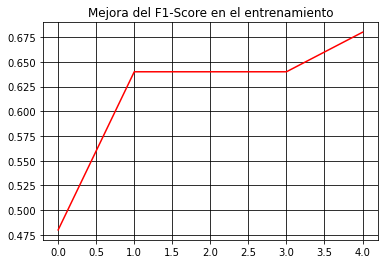

In [13]:
plt.plot(improve,color='red')
plt.grid((50,50),color='black')
plt.title("Mejora del F1-Score en el entrenamiento")

## Evaluación en el conjunto de prueba

In [20]:
toinfer=torch.load("ViTEstDet2022-03-12_bestsofar.pt",map_location=torch.device('cpu'))
c,d=toinfer.eval_model(test_dl)

In [21]:
print(classification_report(c,d)) #Tenemos un rendimiento bastante bueno del modelo

              precision    recall  f1-score   support

           0       0.75      0.50      0.60        18
           1       0.65      0.85      0.74        20

    accuracy                           0.68        38
   macro avg       0.70      0.68      0.67        38
weighted avg       0.70      0.68      0.67        38



# Inferencia sobre cualquier imagen de entrada

In [22]:
mascara=toinfer.predict('1.png')

In [23]:
imagen_original=cv2.imread('1.png')
nmask=cv2.resize(mascara.astype('float32'),(imagen_original.shape[1],imagen_original.shape[0]))

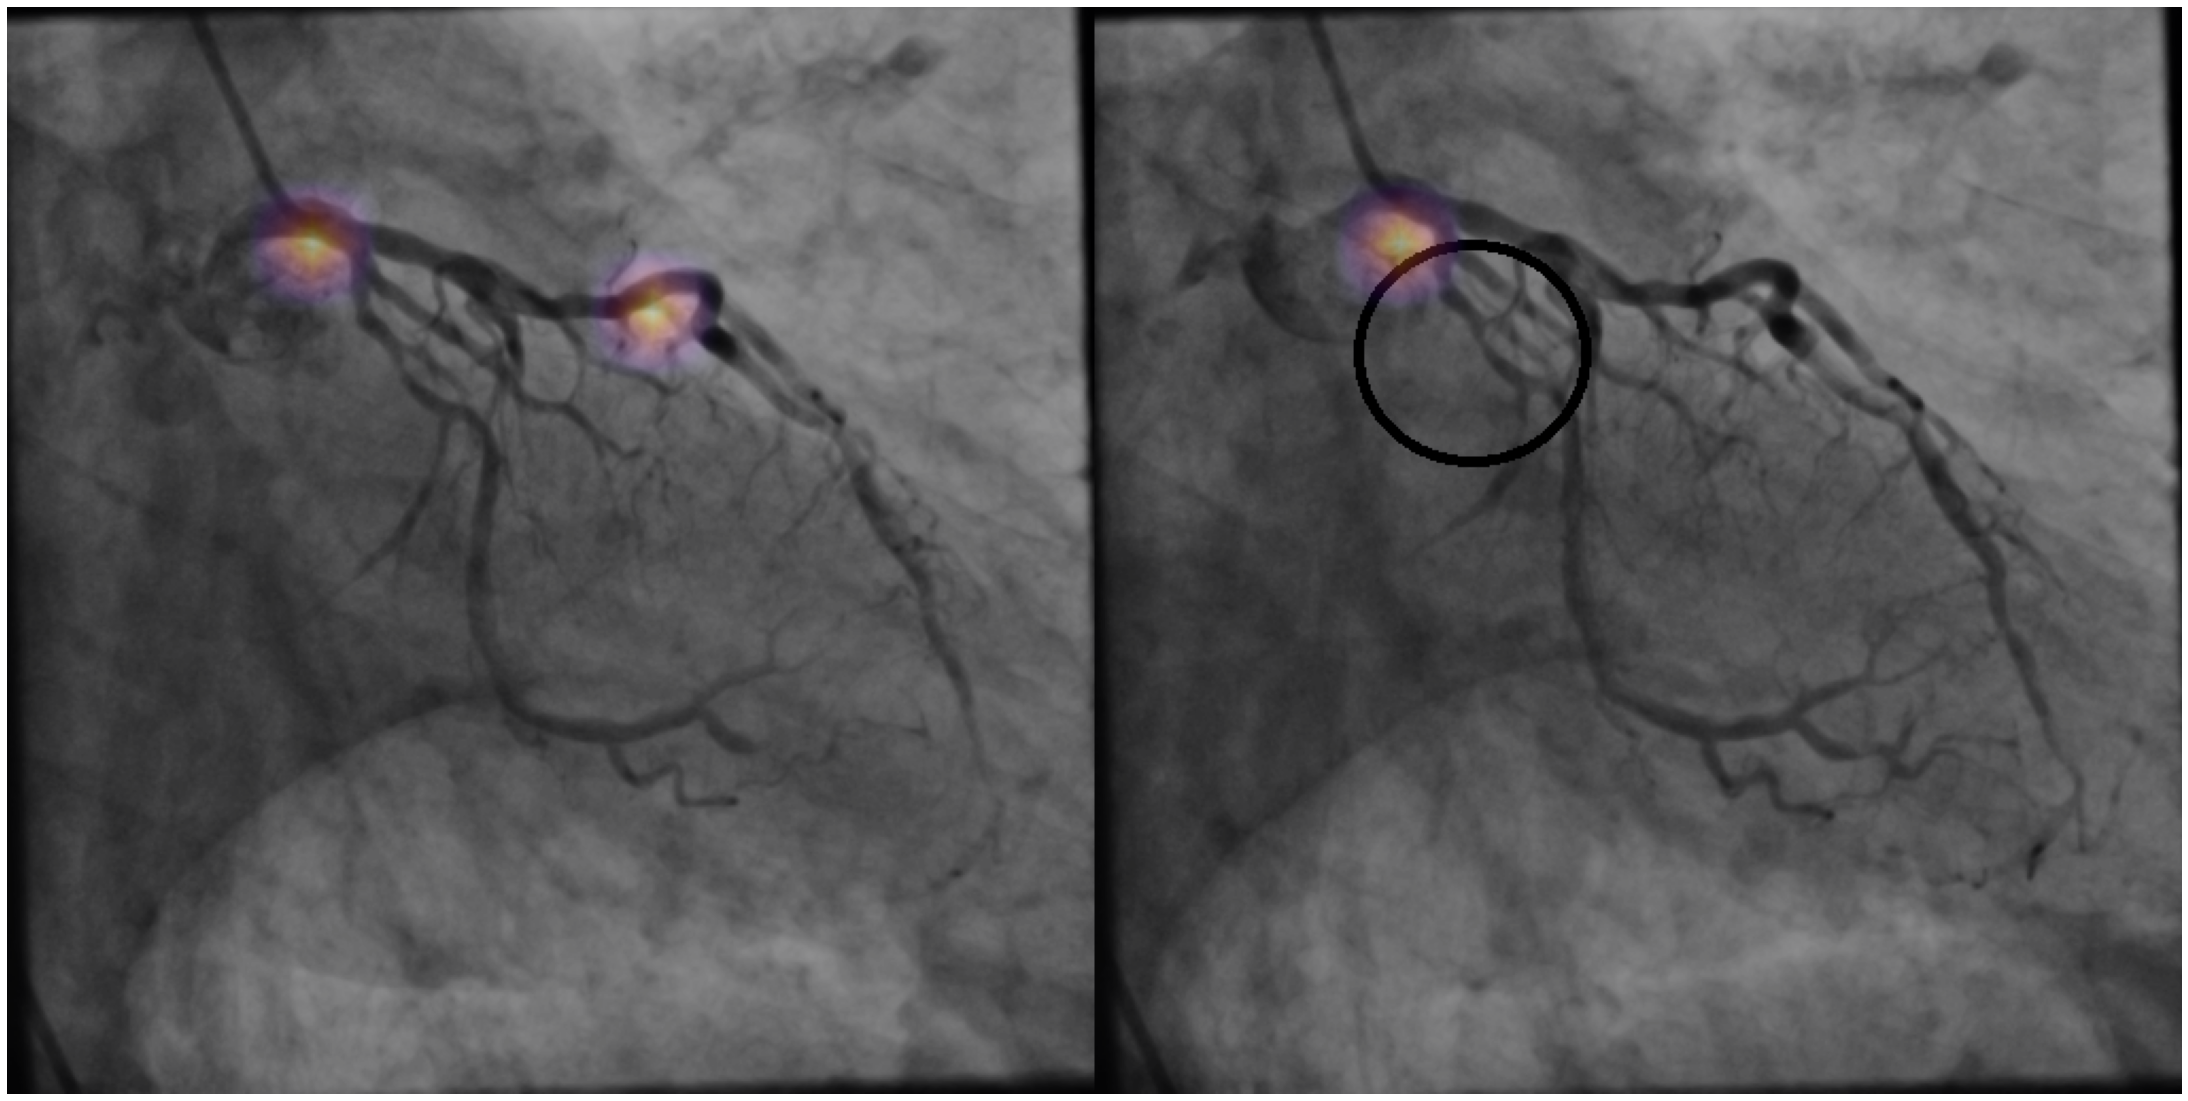

In [24]:
plt.figure(figsize = (50,20))
plt.imshow(imagen_original)
plt.imshow(nmask,alpha=0.3,cmap='inferno')
plt.axis('off')
plt.savefig(model_name+"_inferencia.jpg")

(-0.5, 1023.5, 511.5, -0.5)

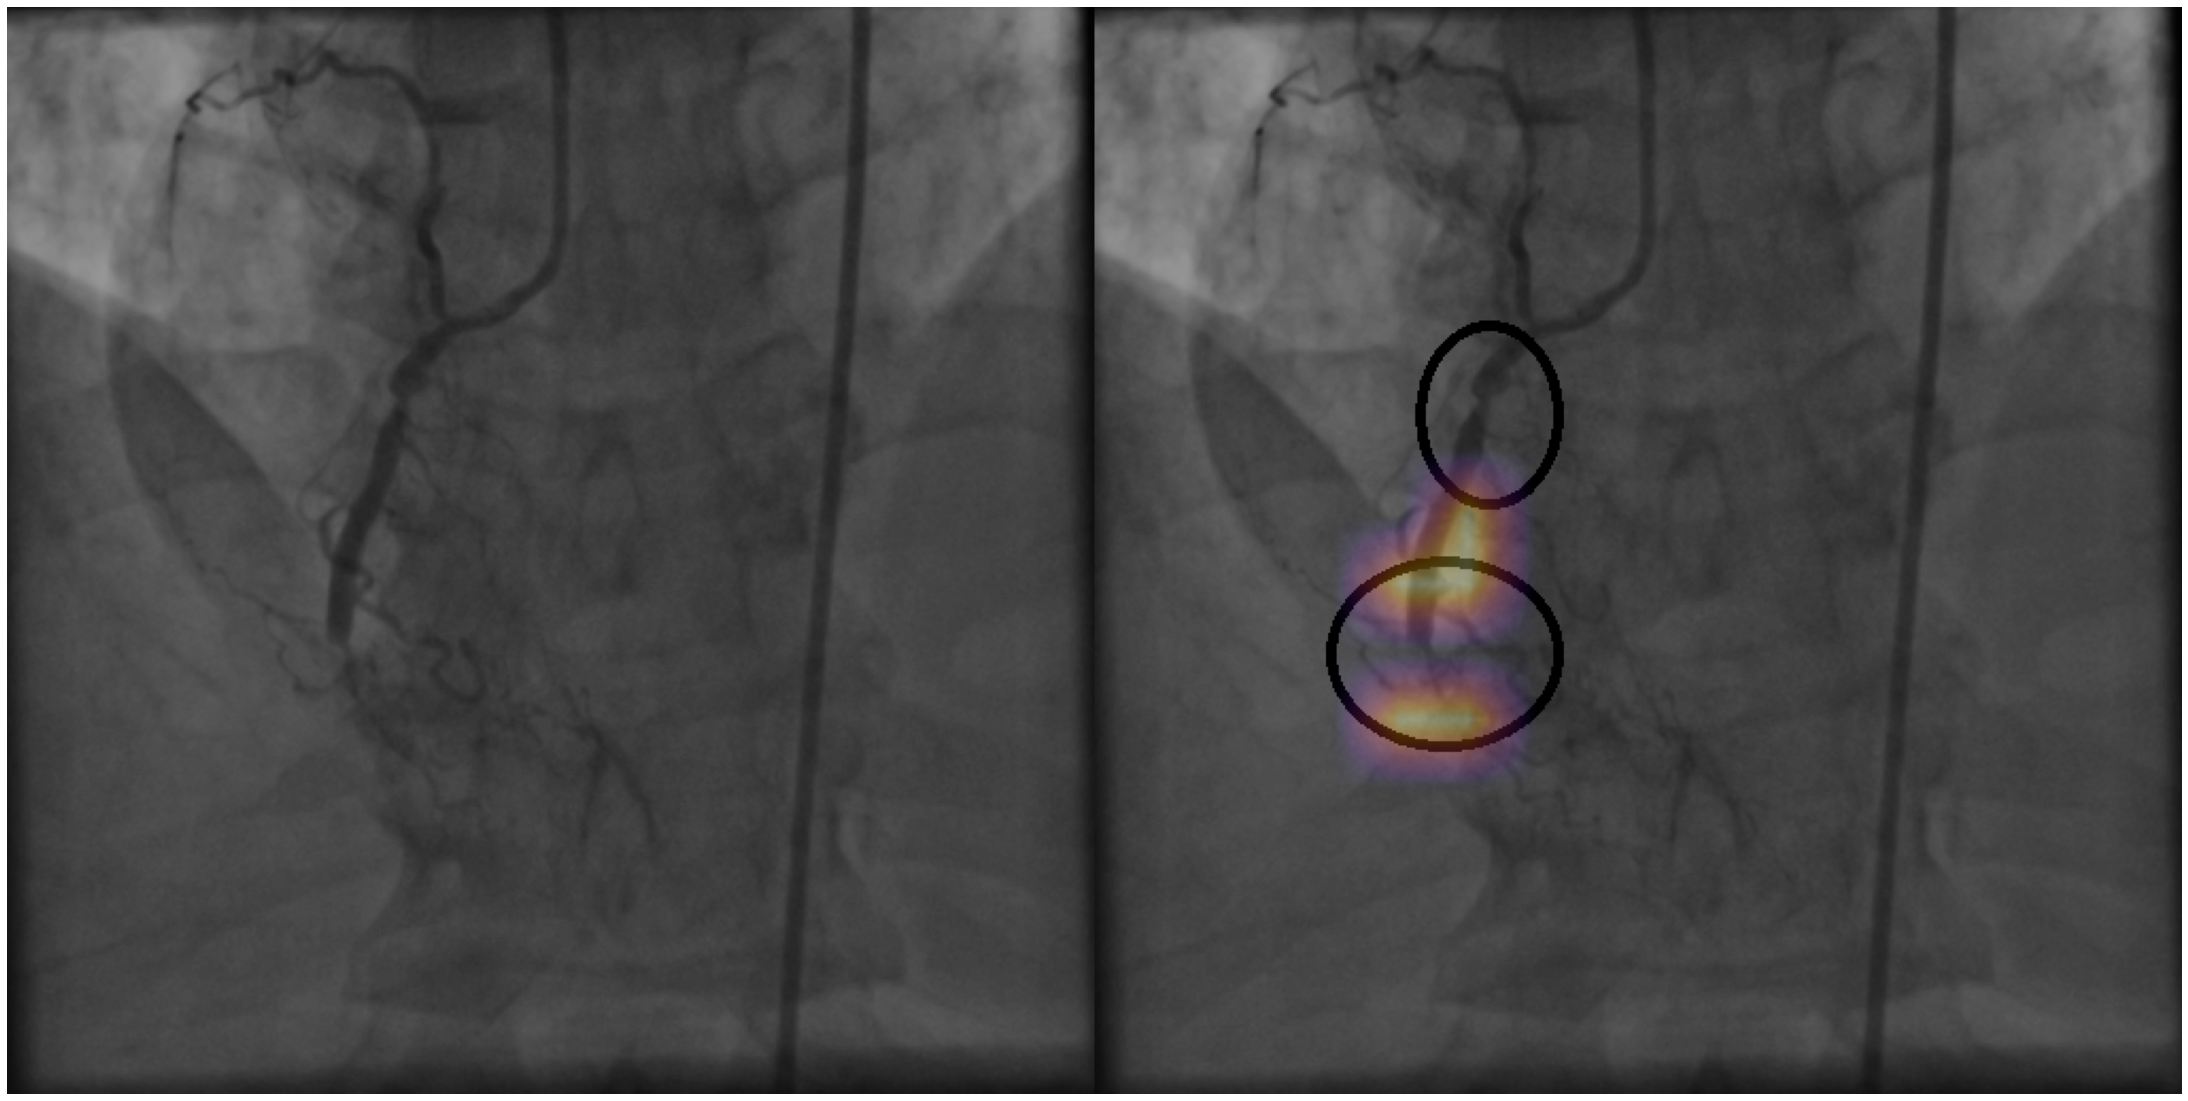

In [25]:
mascara=toinfer.predict('5.png')
imagen_original=cv2.imread('5.png')
nmask=cv2.resize(mascara.astype('float32'),(imagen_original.shape[1],imagen_original.shape[0]))
plt.figure(figsize = (50,20))
plt.imshow(imagen_original)
plt.imshow(nmask,alpha=0.3,cmap='inferno')
plt.axis('off')